## Projet Deep Learning - Luca Delanglade 
### Correction de données à l'aide d'un réseau de neurones intégrant une couche d'embedding
##### Master EBAM - Cours H.Snoussi
L'objectif de ce projet est de mettre au point une approche qui permet de  faire des prédictions sur des données cibles arrondis. Ce projet s'insère dans une mission sur laquelle je travaille actuellement, dans le cadre de mon apprentissage chez Airbus Helicopter. L'objectif de cette mission est de prédire un metric collecté par des capteurs embarqués sur les moteurs d'hélicopter: l'endofluage.
- Supposons un problème à 364 variables pour lequel nous avons à disposition 10K observations. Nous souhaitons prédire par regression linéaire une valeur cible qui est faussée par un arrondis à l'unité, lié au mode d'acquisition des capteurs.
- Dans le cas où la valeur cible n'est pas tronquée, nous connaissons les poids thetai qui permettent de la calculer avec exactitude.
- Nous souhaitons trouver une approche pour neutraliser le biais introduit par la troncature des données cibles.

Pour ce faire, nous avons simulé un dataset, et calculé la valeur cible à l'aide des paramètres thetai connus, puis nous arrondissons à l'unité ces valeurs cibles. Enfin, nous allons chercher à prédire cette valeur cible tronquée.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random
import seaborn as sns

In [3]:
#Data simulée
df=pd.read_csv("data_validation_3.csv")
df=df.sort_values(by=["f_session"]).reset_index().drop("index",axis=1)

#Troncature de l'endofluage à l'unité
df["Endoflu"]=round(df["Endoflu"],-1)

df1=df.copy()
df.head()
df=df1.copy()
#df=df[df["f_session"]<1000]
y=df["Endoflu"]
X=df.iloc[:,2:]

#Normalisation et split
scaler = StandardScaler() 
X = pd.DataFrame(scaler.fit_transform(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5000)

df.head()

,f_session,Endoflu,theta_N1_50_T45_350,theta_N1_50_T45_500,theta_N1_50_T45_600,theta_N1_50_T45_650,theta_N1_50_T45_675,theta_N1_50_T45_700,theta_N1_50_T45_715,theta_N1_50_T45_730,...,theta_N1_104_T45_865,theta_N1_104_T45_880,theta_N1_104_T45_900,theta_N1_104_T45_910,theta_N1_104_T45_920,theta_N1_104_T45_930,theta_N1_104_T45_940,theta_N1_104_T45_950,theta_N1_104_T45_960,theta_N1_104_T45_962
0,0,130.0,21,97,112,67,83,49,40,38,...,0,1,0,1,0,0,0,0,0,1
1,1,100.0,15,110,139,63,80,40,45,35,...,0,1,0,1,0,0,0,0,0,0
2,2,140.0,17,115,109,80,70,49,49,37,...,0,0,0,0,0,0,0,0,0,0
3,3,220.0,21,105,127,83,91,56,55,33,...,0,0,0,1,0,0,0,0,0,0
4,4,80.0,18,86,122,70,72,50,37,42,...,0,0,0,0,0,0,0,0,0,0


## Regression linéaire simple

In [130]:
Model = LinearRegression(fit_intercept=False)
Model=Ridge(alpha=0.001, random_state=99,fit_intercept=True) #positive=True,selection='random',max_iter=1000,alpha=0.0001,

Model = Model.fit(X_train, y_train)

ypred_train=Model.predict(X_train).reshape(-1,1)
ypred_test=Model.predict(X_test).reshape(-1,1)

r2_train=Model.score(X_train,y_train)
r2_test=Model.score(X_test,y_test)
MSE_train=mean_squared_error(y_train,ypred_train)
MSE_test=mean_squared_error(y_test,ypred_test)

print("r2_train: ",round(r2_train,2),"\n","r2_test: ",round(r2_test,2),"\n","\n","MSE_train: ",MSE_train,"\n","MSE_test: ",MSE_test)

r2_train:  1.0 
 r2_test:  1.0 
 
 MSE_train:  7.747948877129595 
 MSE_test:  8.760527352358888


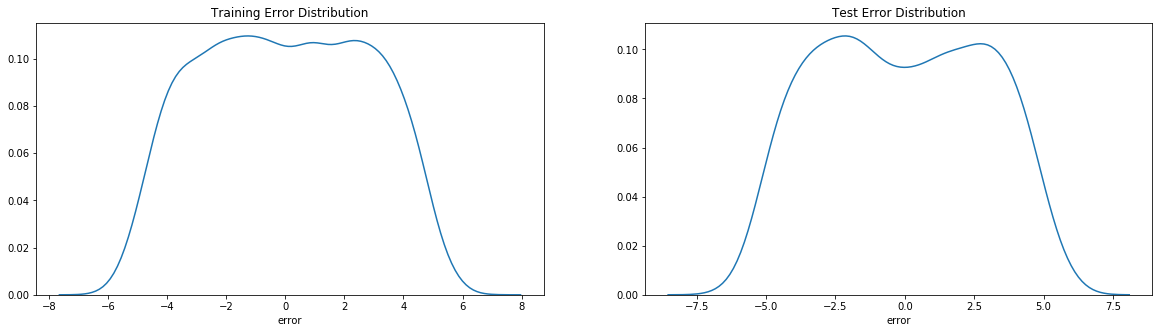

Text(0.5, 1.0, 'Test prédictions')

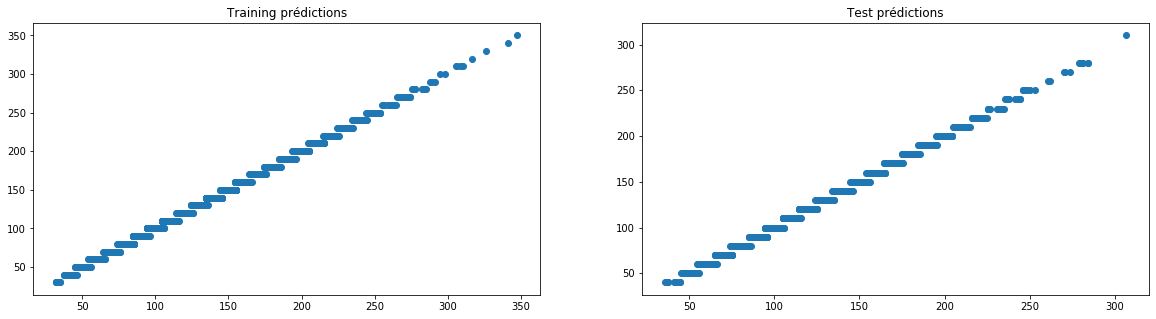

In [131]:
#Analyse de la performance du modèle
ypred_train=pd.Series(Model.predict(X_train)).rename("model_train")
ypred_test=pd.Series(Model.predict(X_test)).rename("model_test")
comp_train=pd.concat([X_train.reset_index(),y_train.reset_index()["Endoflu"],ypred_train],axis=1)
comp_test=pd.concat([X_test.reset_index(),y_test.reset_index()["Endoflu"],ypred_test],axis=1)

comp_train["error"]=(comp_train["Endoflu"]-comp_train["model_train"])#/comp_train["target"]*100
comp_test["error"]=(comp_test["Endoflu"]-comp_test["model_test"])#/comp_train["target"]*100

fig, axe=plt.subplots(1,2,figsize=(20,5), sharex=False) 
sns.distplot(comp_train["error"],hist=False, ax=axe[0])
sns.distplot(comp_test["error"],hist=False, ax=axe[1])
axe[0].set_title('Training Error Distribution')
axe[1].set_title('Test Error Distribution')
plt.show()

fig, axe=plt.subplots(1,2,figsize=(20,5), sharex=False)
axe[0].scatter(x=comp_train["model_train"],y=comp_train["Endoflu"])
axe[1].scatter(x=comp_test["model_test"],y=comp_test["Endoflu"])
axe[0].set_title('Training prédictions')
axe[1].set_title('Test prédictions')


Malgré la relation parfaitement linéaire entre nos variables et la valeur cible, nous observons que le biais introduit génère une erreure quadratique moyenne de 8.8 sur les données de test que l'on peut interpréter facilement à l'aide des graphiques de prédiction. En effet, il y a une discontinuité dans les valeurs prédites (abcisse).

## Deep Learning

Nous allons essayer de mettre au point un réseau de neurones pour neutraliser le biais introduit.

In [46]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Add,Embedding, Reshape
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD,RMSprop
from keras import regularizers

dim = X_train.shape[1]
activation="sigmoid"

In [73]:
#On définit une fonction qui permettra d'analyser les résultats de plusieurs modèles.

def model_analysis(model, epoch, verbose, start_loss):
    #Entrainement du modèle
    model.fit(np.array(X_train), np.array(y_train), epochs=epoch, verbose=verbose)#, callbacks=[lr_schedule], verbose=0)
    
    #MSE par itération
    loss = model.history.history['loss'][start_loss:]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.title("MSE per iteration")
    plt.show()
    ypred_test=pd.Series(model.predict(np.array(X_test)).reshape(-1)).rename("model_test")
    ypred_train=pd.Series(model.predict(np.array(X_train)).reshape(-1)).rename("model_train")
    MSE_train=mean_squared_error(y_train,ypred_train)
    MSE_test=mean_squared_error(y_test,ypred_test)
    print("MSE_train: ",MSE_train,"MSE_test: ",MSE_test)
    
    #Distribution des erreurs corrélation prédiction/valeur cible
    comp_train=pd.concat([X_train.reset_index(),y_train.reset_index()["Endoflu"],ypred_train],axis=1)
    comp_test=pd.concat([X_test.reset_index(),y_test.reset_index()["Endoflu"],ypred_test],axis=1)
    comp_train["error"]=(comp_train["Endoflu"]-comp_train["model_train"])
    comp_test["error"]=(comp_test["Endoflu"]-comp_test["model_test"])

    fig, axe=plt.subplots(1,2,figsize=(20,5), sharex=False) 
    sns.distplot(comp_train["error"],hist=False, ax=axe[0])
    sns.distplot(comp_test["error"],hist=False, ax=axe[1])
    axe[0].set_title('Training Error Distribution')
    axe[1].set_title('Test Error Distribution')
    plt.show()

    fig, axe=plt.subplots(1,2,figsize=(20,5), sharex=False)
    axe[0].scatter(x=comp_train["model_train"],y=comp_train["Endoflu"])
    axe[1].scatter(x=comp_test["model_test"],y=comp_test["Endoflu"])
    axe[0].set_title('Training prédictions')
    axe[1].set_title('Test prédictions')
    return

### I. Single unit NN

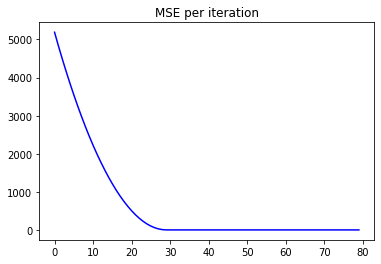

MSE_train:  8.241353648043512 MSE_test:  9.275774528533221


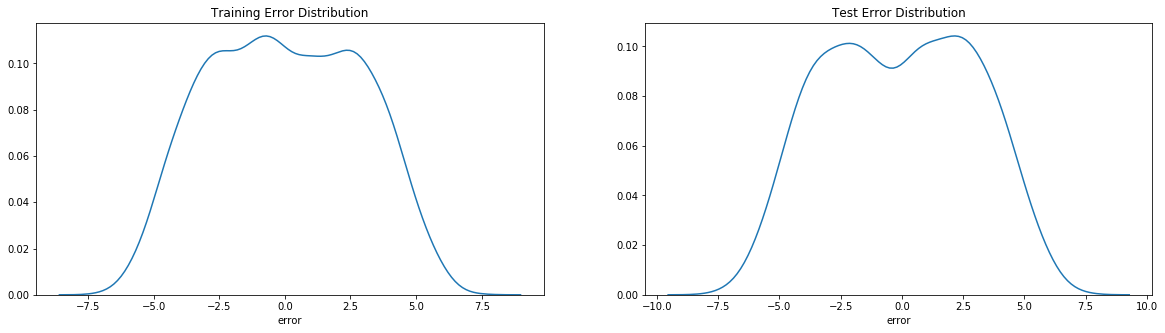

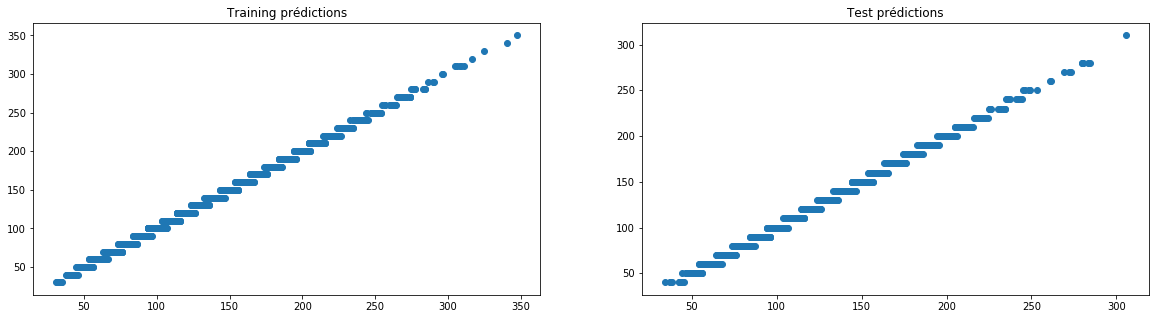

In [35]:
model1 = Sequential([ Dense(1, activation="linear", input_dim=dim,kernel_initializer='normal')])
optimizer = RMSprop(0.0099) #SGD(lr=1e-10, momentum=0.9)

model1.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(np.array(X_train), np.array(y_train), epochs=100, verbose=False)
model_analysis(model1,start_loss=20)

On retrouve bien les mêmes résultats qu'avec la régression linéaire simple. Ensuite nous allons complexifier le modèle

### II. Several layers NN

Epoch 1/100
8000/8000 [==============================] - 2s 206us/sample - loss: 2729.5774
Epoch 2/100
8000/8000 [==============================] - 1s 75us/sample - loss: 482.1486
Epoch 3/100
8000/8000 [==============================] - 1s 75us/sample - loss: 327.8373
Epoch 4/100
8000/8000 [==============================] - 1s 75us/sample - loss: 237.4406
Epoch 5/100
8000/8000 [==============================] - 1s 75us/sample - loss: 196.6139
Epoch 6/100
8000/8000 [==============================] - 1s 80us/sample - loss: 162.1610
Epoch 7/100
8000/8000 [==============================] - 1s 74us/sample - loss: 141.1305
Epoch 8/100
8000/8000 [==============================] - 1s 76us/sample - loss: 124.4765
Epoch 9/100
8000/8000 [==============================] - 1s 74us/sample - loss: 107.0637
Epoch 10/100
8000/8000 [==============================] - 1s 75us/sample - loss: 97.6291
Epoch 11/100
8000/8000 [==============================] - 1s 81us/sample - loss: 89.9017
Epoch 12/100
8000/8

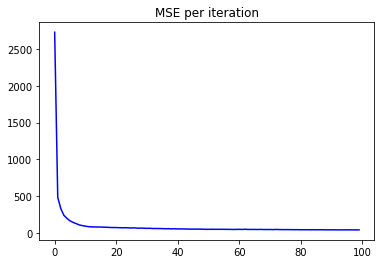

MSE_train:  17.07685463322264 MSE_test:  17.963084556538888


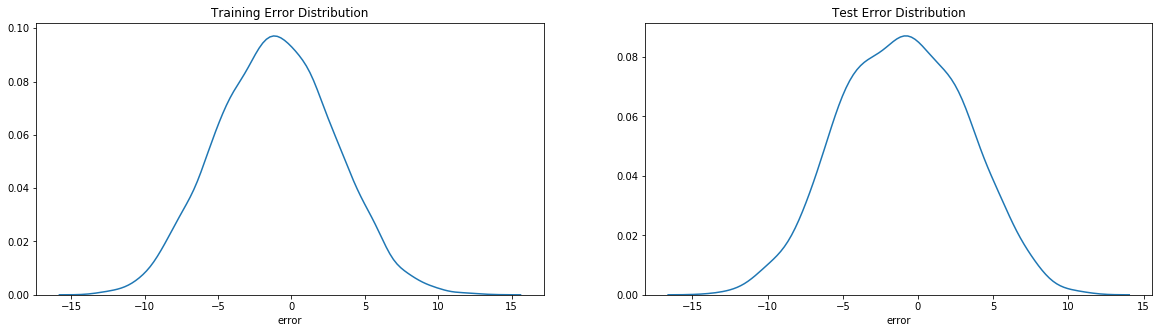

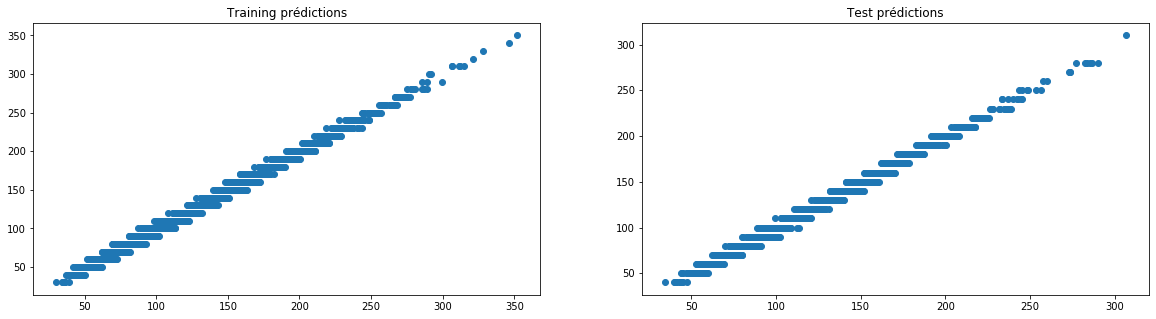

In [23]:
model3 = Sequential([Dense(50, activation="linear", input_dim=dim,kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.1),activity_regularizer=regularizers.l1(0.1)),
                     Dense(50, activation="linear"),
                     Dense(50, activation="linear"),
                     Dense(1, activation="linear")])

optimizer = RMSprop(0.0099)
model3.compile(loss='mean_squared_error', optimizer=optimizer)

model_analysis(model3,epoch=100,verbose=True, start_loss=0)

En conclusion, on voit bien que le réseau de neurones dans sa forme fully connected, ne peut pas neutraliser le biais introduit.

### III. With Embedding layer

Nous souhaiterions faire apprendre au modèle les inconnus suivantes: les n (n=nombre d'observations du dataset) troncatures qui ont été appliquées à chaque valeur cible. Nous allons ajouter un terme correctif à chaque prédiction de façon à faire apparaitre ces inconnnus. Pour cela nous utiliserons une couche d'embedding pour générer un scalaire qui sera additionné à la couche dense qui opère le calcul des prédictions.

In [136]:
#Couche d'embedding qui prend en entrée l'index de la session
input1 = Input(shape=[1],name='session')
embedding = Embedding(len(X),1, input_length=1,name='Embedding')(input1)
x1 = Flatten(name='vector')(embedding)

#Single unit NN comme précedémment. Une cellule qui calcule X.T.dot(theta)
input2 = Input(shape=(364,),name='training_set')
x2 = Dense(1, activation='linear')(input2)

out = Add()([x1, x2])

model4 = Model(inputs=[input1, input2], outputs=out)

optimizer = RMSprop(0.0099)
model4.compile(loss='mean_squared_error', optimizer=optimizer)
model4.summary()

index=list(range(len(X)))

model4.fit([index,X], np.array(y), epochs=500, verbose=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
session (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 1, 1)         10000       session[0][0]                    
__________________________________________________________________________________________________
training_set (InputLayer)       (None, 364)          0                                            
__________________________________________________________________________________________________
vector (Flatten)                (None, 1)            0           Embedding[0][0]                  
__________________________________________________________________________________________________
dense_65 (

Ainsi, nous obtenons un modèle à 8001+364 paramètres par concaténation d'une couche d'embedding et d'une couche dense.

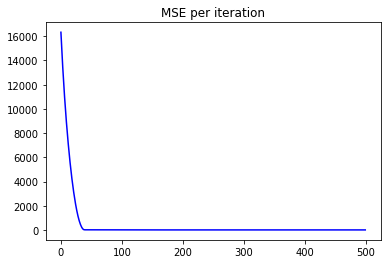

In [137]:
#MSE par itération
loss = model4.history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title("MSE per iteration")
plt.show()

MSE:  0.15021383897323576


/data/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/data/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


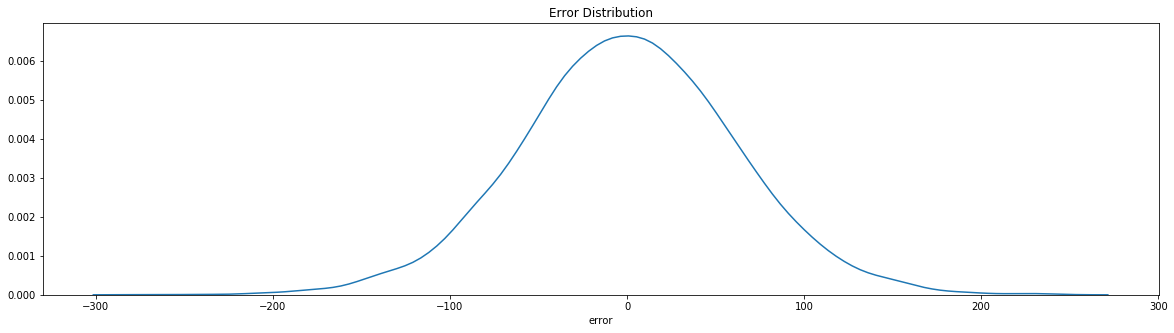

Text(0.5, 1.0, 'Prédictions')

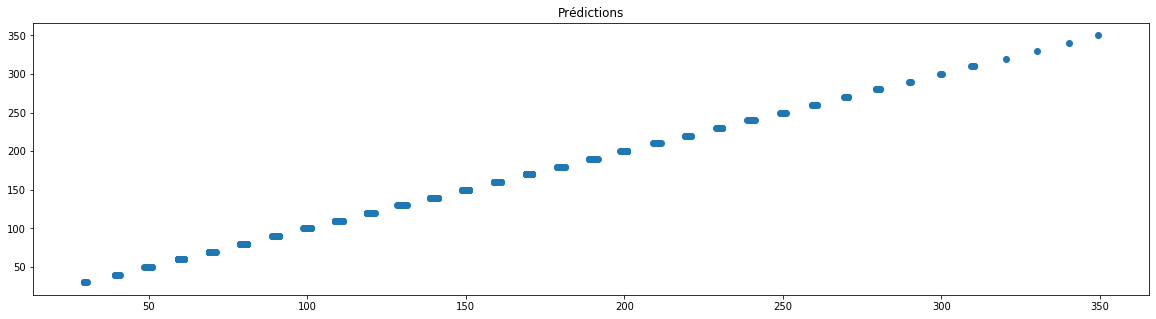

In [138]:
#Analyse des performances
ypred=pd.Series(model4.predict([index,np.array(X)]).reshape(-1)).rename("model")

MSE=mean_squared_error(y,ypred)

print("MSE: ",MSE)

comp=pd.concat([X.reset_index(),y.reset_index()["Endoflu"],ypred],axis=1)
comp["error"]=(comp_train["Endoflu"]-comp["model"])

fig, axe=plt.subplots(1,1,figsize=(20,5), sharex=False) 
sns.distplot(comp["error"],hist=False, ax=axe)
axe.set_title('Error Distribution')

plt.show()

fig, axe=plt.subplots(1,1,figsize=(20,5), sharex=False)
axe.scatter(x=comp["model"],y=comp["Endoflu"])
axe.set_title('Prédictions')

En ajoutant des variables au problème, le modèle est parvenu à neutraliser le biais introduit et à faire tendre la MSE vers 0.15.

In [145]:
troncature=model4.get_weights()[0].reshape(-1)
troncature

array([-3.354972 ,  6.330262 ,  3.4960434, ..., -0.4491297,  3.2699835,
       -3.7440286], dtype=float32)

In [140]:
theta=model4.get_weights()[1].reshape(-1)

In [142]:
#X.iloc[0,:].dot(theta)+troncature[0]
